# **Data Processing**

In [1]:
#We install our data generator using this link
!pip install trdg

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.6/98.6 MB 6.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
Reason for being yanked: Doesn't work with Python 2
  Created wheel for diffimg: filename=diffimg-0.2.3-py3-none-any.whl size=4019 sha256=5af5c3045f73f95690d5539871ddc80e660773c9e6af537f1212d2af034a7bdb
  Stored in directory: /root/.cache/pip/wheels/90/57/92/d4259a51f20cf92a473b567a009674e3390852b7fab19be6dc
  Created wheel for wikipedia: filename=wikipedia-1.4.0-py3-none-any.whl size=11680 sha256=5791853511486c99047b87f35167510c7f91bdf7104cdfb4d1fb8162438ec0f6
  Stored in directory: /root/.cache/pip/wheels/5e/b6/c5/93f3dec388ae76edc830cb42901bb0232504dfc0df02fc50de
Successfully built diffimg wikipedia


In [5]:

from trdg.generators import (
     GeneratorFromDict,
     GeneratorFromRandom,
     GeneratorFromWikipedia,
 )
from IPython.display import display
from google.colab import drive
import os
from PIL import Image
import numpy as np

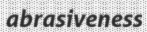

abrasiveness


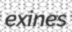

exines


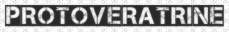

protoveratrine


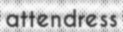

attendress


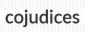

cojudices


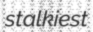

stalkiest


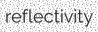

reflectivity


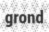

grond


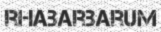

rhabarbarum


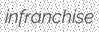

infranchise


In [6]:
#Testing to see if the dataset is able to produce images and correct labels for the images
#Create an instance of the GeneratorFromDict class to generate 100 images
generator = GeneratorFromDict(
      count=10,
      language="en",
      background_type=2,
      random_skew= True,
      blur=1,
      random_blur= True
)

#Generate images and display them
for img, lbl in generator:
    display(img)  # This will display the image in the notebook
    print(lbl)

In [ ]:
from google.colab import drive
import os
# Mount Google Drive
drive.mount('/content/drive')

# Set up the paths for the dataset directories in Google Drive
dataset_root = '/content/drive/My Drive/dataset_10k'
train_dir = os.path.join(dataset_root, 'train')
val_dir = os.path.join(dataset_root, 'val')
test_dir = os.path.join(dataset_root, 'test')

# if the dirs dont exists this creates them so if someone accidentally deletes
# a file we dont have to delete a thousand immages
os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

Mounted at /content/drive


In [ ]:
# Define the split sizes
total_images = 5000
train_split = 0.7
val_split = 0.12
test_split = 0.18  # Or you could use 1 - train_split - val_split to ensure they sum to 100%

# Calculate the number of images for each split
train_count = int(total_images * train_split)
val_count = int(total_images * val_split)
test_count = total_images - train_count - val_count  # The remainder goes to test to ensure the total is 1000

# Create the generators for each dataset split
train_generator = GeneratorFromDict(count=train_count, language="en")
val_generator = GeneratorFromDict(count=val_count, language="en")
test_generator = GeneratorFromDict(count=test_count, language="en")

# Define a function to save images from a generator to a directory
def save_images(generator, directory):
    for i, (img, lbl) in enumerate(generator):
        filename = f'{lbl}_{i}.jpg'
        img.save(os.path.join(directory, filename))

# Save the images for each dataset split
save_images(train_generator, train_dir)
save_images(val_generator, val_dir)
save_images(test_generator, test_dir)

print('Image generation complete.')

In [ ]:
#preprocessing for easier learning:
def preprocess_images(directory, target_size=(170, 32), color_mode='grayscale'):
    for img_name in os.listdir(directory):
        img_path = os.path.join(directory, img_name)
        img = Image.open(img_path)

        # Resize image
        img = img.resize(target_size, Image.ANTIALIAS)

        # Convert to grayscale
        if color_mode == 'grayscale':
            img = img.convert('L')

        # Normalize pixel values
        img_array = np.asarray(img) / 255.0

        # Save preprocessed image
        img = Image.fromarray((img_array * 255).astype(np.uint8))
        img.save(img_path)

# Apply preprocessing to each dataset split
preprocess_images(val_dir)

print('Preprocessing complete.')


In [ ]:
#immage after it has been preprocces
example_image_path = os.listdir(train_dir)[0]  # Get the first image in the directory
example_image_full_path = os.path.join(train_dir, example_image_path)

# Open and display the image
example_image = Image.open(example_image_full_path)
display(example_image)

# **Baseline Model**

In [ ]:
!pip install easyocr

In [ ]:
import numpy as np
import time
import torch
import torchvision
import easyocr
from matplotlib import pyplot as pyplot
import random

In [ ]:
#Initializing EasyOCR Baseline model
baseline = easyocr.Reader(['en'], gpu=False)

In [ ]:
#Performing a random sanity test on our dataset using EasyOCR model
random_path = random.choice(os.listdir(train_dir))
random_image_full_path = os.path.join(train_dir, random_path)
random_image = Image.open(random_image_full_path)
display(random_image)
label = random_path.split("_")[0]
print("label:",label)

baseline_result = baseline.readtext(random_image_full_path)
print(baseline_result)


In [ ]:
#Now that we have instantiated our Baseline model which is working in inference,
#we can proceed to finding correct/incorrect, closeness (levenshtein distance algorithm) and confidence level
#average statistics. We will use the help of jellyfish python library.
!pip install jellyfish

In [ ]:
import jellyfish

In [ ]:
#Testing EasyOCR over our testing dataset:
correctCount = 0
levSum = 0
confidenceSum = 0
testLength = len(os.listdir(test_dir))
numFails = 0

for image in os.listdir(test_dir):
  image_full_path = os.path.join(test_dir,image)
  trueLabel = image.split("_")[0]
  results = baseline.readtext(image_full_path)

  if not results:
    numFails += 1
    continue
  predictedLabel = results[0][-2]
  confidence = results[0][-1]

  lev = jellyfish.levenshtein_distance(trueLabel,predictedLabel)
  levSum += lev

  confidenceSum += confidence

  if trueLabel == predictedLabel:
    correctCount += 1

percentCorrect = (correctCount/testLength)*100
confidenceAvg = (confidenceSum/testLength)*100
levAvg = levSum/testLength
percentFails = (numFails/testLength)*100

print("EasyOCR Performance Over Test Data:")
print(f"Percent of predictions that were exactly correct: {percentCorrect}")
print(f"Average prediction confidence level: {confidenceAvg}")
print(f"Averege Levenshtein Distance for predicted label vs. true label: {levAvg}")
print(f"Percent failures (where model returned nothing): {percentFails}")

# **Data Loader for training and Helper Functions**

In [ ]:
from google.colab import drive
import os
# Mount Google Drive
drive.mount('/content/drive', force_remount=True)

# Set up the paths for the dataset directories in Google Drive
dataset_root = '/content/drive/My Drive/dataset_10k'
train_dir = os.path.join(dataset_root, 'train')
val_dir = os.path.join(dataset_root, 'val')
test_dir = os.path.join(dataset_root, 'test')


Mounted at /content/drive


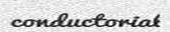

In [ ]:
from IPython.display import display
from google.colab import drive
import os
from PIL import Image
import numpy as np
#immage after it has been preprocces
example_image_path = os.listdir(train_dir)[0]  # Get the first image in the directory
example_image_full_path = os.path.join(train_dir, example_image_path)

# Open and display the image
example_image = Image.open(example_image_full_path)
display(example_image)

In [ ]:
#Letters present in the Label Text
letters= "0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ'-.!'"
#image height
img_h=32
#image width
img_w=170
#image Channels
img_c=1
# classes for softmax with number of letters +1 for blank space in ctc
num_classes=len(letters)+1
batch_size=32
max_length=25 # considering max length of ground truths labels to be 25

In [ ]:
def create_char_dict(letters):
    """Create a dictionary mapping from character to a numerical index."""
    # Add 1 to account for the blank label in CTC
    return {char: i + 1 for i, char in enumerate(letters)}

def encode_text(text, char_dict):
    """Encode a text string into a sequence of indices based on a character dictionary."""
    return [char_dict[char] for char in text if char in char_dict]


In [ ]:
def create_reversed_char_dict(char_dict):
    """Create a dictionary mapping from numerical index to character."""
    # Reverse the char_dict mapping from {char: index} to {index: char}
    return {index: char for char, index in char_dict.items()}

In [ ]:
def decode_ctc(predictions, index_char_dict):
    """Decode CTC predictions to a human-readable string using a reversed char dict."""
    decoded_pred = []
    prev = None
    for i in predictions:
        # Check if the index is within the valid range and not the blank label
        if i != prev and i in index_char_dict:
            decoded_pred.append(index_char_dict[i])
        prev = i
    return ''.join(decoded_pred)

In [ ]:
import os
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torch.nn.utils.rnn import pad_sequence

def custom_collate_fn(batch):
    images, labels, input_lengths, label_lengths = zip(*batch)
    images = torch.stack(images, 0)

    labels = pad_sequence(labels, batch_first=True, padding_value=0)

    input_lengths = torch.tensor(input_lengths)
    label_lengths = torch.tensor(label_lengths)

    return images, labels, input_lengths, label_lengths

class ImageDataset(Dataset):
    def __init__(self, directory, transform=None, char_dict=None):
        self.directory = directory
        self.transform = transform
        self.filenames = os.listdir(directory)
        self.char_dict = char_dict

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, idx):
        img_path = os.path.join(self.directory, self.filenames[idx])
        image = Image.open(img_path).convert("L")
        label_text = self.filenames[idx].split('_')[0].upper()
        label_seq = encode_text(label_text, self.char_dict)
        label_length = len(label_seq)

        if self.transform:
            image = self.transform(image)
            # After transformations, image is a tensor, and its size can be directly accessed
            sequence_length = torch.tensor([image.shape[2]], dtype=torch.int)
        else:
            # Fallback to original width if no transformation is applied
            sequence_length = torch.tensor([image.size[0]], dtype=torch.int)

        return image, torch.tensor(label_seq, dtype=torch.int), sequence_length, torch.tensor([label_length], dtype=torch.int)

transformations = transforms.Compose([
    transforms.Grayscale(),  # Ensure images are in grayscale
    transforms.ToTensor(),  # Convert images to PyTorch tensors
    transforms.Normalize(mean=[0.5], std=[0.5]),  # Normalize grayscale images
])

char_dict = create_char_dict(letters)
train_dataset = ImageDataset(directory='/content/drive/My Drive/dataset_10k/train', transform=transformations, char_dict = char_dict)
validation_dataset = ImageDataset(directory='/content/drive/My Drive/dataset_10k/val', transform=transformations, char_dict = char_dict)
test_dataset = ImageDataset(directory='/content/drive/My Drive/dataset_10k/test', transform=transformations, char_dict = char_dict)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=custom_collate_fn)
validation_loader = DataLoader(validation_dataset, batch_size=32, shuffle=False, collate_fn=custom_collate_fn)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, collate_fn=custom_collate_fn)

training_samples = len(train_loader.dataset)
validation_samples = len(validation_loader.dataset)
testing_samples = len(test_loader.dataset)
print(f"Total number of training samples: {training_samples}")
print(f"Total number of validation samples: {validation_samples}")
print(f"Total number of testing samples: {testing_samples}")

Total number of training samples: 7000
Total number of validation samples: 1200
Total number of testing samples: 1800


# **Primary Model**

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import torch
import torch.nn as nn
import torch.nn.functional as F

#This model architecture and code was inspired by the following sources:
#https://arxiv.org/pdf/1507.05717.pdf (almost all of the below sources used this architecture)
#https://github.com/GitYCC/crnn-pytorch/blob/master/src/train.py#L51
#https://github.com/meijieru/crnn.pytorch/blob/master/
#https://github.com/pythonlessons/mltu/blob/main/Tutorials/08_handwriting_recognition_torch/
#https://medium.com/analytics-vidhya/image-text-recognition-738a368368f5
class ImageTextRecognizer(nn.Module):
    def __init__(self, name, img_w, img_h, num_classes, max_length, drop_out_rate=0.35):
        super(ImageTextRecognizer, self).__init__()
        self.name = name
        self.conv1 = nn.Conv2d(1, 64, kernel_size=3,padding=1)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.conv5 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.bn5 = nn.BatchNorm2d(512)
        self.conv6 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.bn6 = nn.BatchNorm2d(512)
        self.conv7 = nn.Conv2d(512, 512, kernel_size=2, padding=0)

        self.pool1 = nn.MaxPool2d(kernel_size=2, stride = 2)
        self.pool2 = nn.MaxPool2d((2, 2), (2, 1), (0, 1))

        #CNN to RNN
        self.lstm1 = nn.LSTM(512, 256, bidirectional=True)
        self.lstm2 = nn.LSTM(256, 256, bidirectional=True)

        self.fc1 = nn.Linear(256*2, 256)
        self.fc2 = nn.Linear(256*2, num_classes)

    def forward(self,x):
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        x = F.relu(self.conv2(x))
        x = self.pool1(x)
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = self.pool2(x)
        x = F.relu(self.conv5(x))
        x = self.bn5(x)
        x = F.relu(self.bn5(self.conv6(x)))
        x = self.pool2(x)
        x = F.relu(self.bn6(self.conv7(x)))

        b, c, h, w = x.size()
        assert h == 1, "the height of conv must be 1"
        x = x.squeeze(2)
        x = x.permute(2, 0, 1)  # [w, b, c]

        x, _ = self.lstm1(x)
        T, b, h = x.size()
        x = x.view(T*b,h)
        x = self.fc1(x)
        x = x.view(T,b,-1)

        x, _ = self.lstm2(x)
        T, b, h = x.size()
        x = x.view(T*b,h)
        x = self.fc2(x)
        x = x.view(T,b,-1)

        x = F.log_softmax(x, 2)
        return x

# **Training Function**

In [ ]:
!pip install python-Levenshtein
import Levenshtein as lev

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 177.4/177.4 kB 4.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 16.9 MB/s eta 0:00:00


In [ ]:
def get_model_name(name, batch_size, learn_rate, epoch):
    """ Generate a name for the model consisting of all the hyperparameter values

    Args:
        config: Configuration object containing the hyperparameters
    Returns:
        path: A string with the hyperparameter name and value concatenated
    """
    path = "model_{0}_bs{1}_lr{2}_epoch{3}".format(name,
                                                   batch_size,
                                                   learn_rate,
                                                   epoch)
    return path
def plot_training_curve(path):
    """ Plots the training curve for a model run, given the csv files
    containing the train/validation error/loss.

    Args:
        path: The base path of the csv files produced during training
    """
    import matplotlib.pyplot as plt
    train_err = np.loadtxt("{}_train_err.csv".format(path))
    val_err = np.loadtxt("{}_val_err.csv".format(path))
    train_loss = np.loadtxt("{}_train_loss.csv".format(path))
    val_loss = np.loadtxt("{}_val_loss.csv".format(path))
    train_leven = np.loadtxt("{}_train_leven.csv".format(path))
    val_leven = np.loadtxt("{}_val_leven.csv".format(path))

    plt.title("Train vs Validation Exact Match Rate")
    n = len(train_err) # number of epochs
    plt.plot(range(1,n+1), train_err, label="Train")
    plt.plot(range(1,n+1), val_err, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Exact Match Rate")
    plt.legend(loc='best')
    plt.show()

    plt.title("Train vs Validation Levenshtein Distance")
    n = len(train_leven) # number of epochs
    plt.plot(range(1,n+1), train_leven, label="Train")
    plt.plot(range(1,n+1), val_leven, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Levenshtein Distance")
    plt.legend(loc='best')
    plt.show()

    plt.title("Train vs Validation Loss")
    plt.plot(range(1,n+1), train_loss, label="Train")
    plt.plot(range(1,n+1), val_loss, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc='best')
    plt.show()

def batch_decode_ctc(preds, input_lengths, char_list):
    decoded_batch = []
    start = 0
    for length in input_lengths:
        # Extract the sequence from the batch
        sequence = preds[start:start + length]
        # Decode the sequence to a string
        decoded_sequence = decode_ctc(sequence.tolist(), char_list)
        decoded_batch.append(decoded_sequence)
        start += length
    return decoded_batch

def groundtruth_decode_ctc(labels, label_lengths, index_dict):
    decoded_ground_truths = []
    for idx, label_sequence in enumerate(labels):
        actual_length = label_lengths[idx]

        decoded_sequence = decode_ctc(label_sequence[:actual_length].tolist(), index_dict)
        decoded_string = ''.join(decoded_sequence)

        decoded_ground_truths.append(decoded_string)
    return decoded_ground_truths

def calculate_exact_match_accuracy(decoded_batch, ground_truth):
    correct = sum(pred == truth for pred, truth in zip(decoded_batch, ground_truth))
    return correct / len(ground_truth) if ground_truth else 0

def calculate_average_levenshtein(decoded_batch, ground_truth):
    total_distance = sum(lev.distance(pred, truth) for pred, truth in zip(decoded_batch, ground_truth))
    return total_distance / len(ground_truth) if ground_truth else 0

In [ ]:
ctc_loss = nn.CTCLoss(blank=0, zero_infinity=True)

In [ ]:
import torch
import torch.optim as optim
import numpy as np
import math


def train(model, train_loader, val_loader, batch_size=32, num_epochs=20, learn_rate=0.001):
    torch.manual_seed(1000)
    optimizer = optim.Adam(model.parameters(), lr=learn_rate)

    train_accur = np.zeros(num_epochs)
    train_leven = np.zeros(num_epochs)
    train_loss = np.zeros(num_epochs)
    val_accur = np.zeros(num_epochs)
    val_leven = np.zeros(num_epochs)
    val_loss = np.zeros(num_epochs)

    char_dict = create_char_dict(letters)
    index_dict = create_reversed_char_dict(char_dict)

    print ("Training Started...")
    for epoch in range(num_epochs):
        model.train()
        total_train_loss = 0.0
        total_train_accur = 0.0
        total_train_leven = 0.0
        decoded_batch = []
        for imgs, labels, input_lengths, label_lengths in train_loader:
            imgs = imgs.cuda() if torch.cuda.is_available() else imgs
            labels = labels.cuda() if torch.cuda.is_available() else labels

            optimizer.zero_grad()
            logits = model(imgs)

            input_lengths = torch.tensor([logits.size(0)] * logits.shape[1], dtype=torch.int32)

            # print("logits:", logits.shape)  # Tensor of images
            # print("labels:", labels.shape)  # Tensor of encoded labels
            # print("input_lengths:", input_lengths.shape)  # Lengths of each input sequence
            # print("label_lengths:", label_lengths.shape)  # Lengths of each target sequence

            # Calculate CTC Loss
            loss = ctc_loss(logits, labels, input_lengths, label_lengths)

            loss.backward()
            optimizer.step()
            total_train_loss += loss.item()

            # Decode predictions
            _, preds = torch.max(logits, 2)  # Take the index of the highest probability for each timestep
            preds = preds.transpose(1, 0).contiguous().view(-1)  # Rearrange for decoding
            decoded_batch = batch_decode_ctc(preds, input_lengths, index_dict)
            # print(decoded_batch)
            ground_truth = groundtruth_decode_ctc(labels, label_lengths, index_dict)

            total_train_accur += calculate_exact_match_accuracy(decoded_batch, ground_truth)
            total_train_leven += calculate_average_levenshtein(decoded_batch, ground_truth)

        train_loss[epoch] = float(total_train_loss) / len(train_loader)
        train_accur[epoch] = float(total_train_accur) / len(train_loader)
        train_leven[epoch] = float(total_train_leven) / len(train_loader)

        #Validation
        # print ("Validation for this epoch Started...")
        model.eval()
        total_val_loss = 0.0
        total_val_accur = 0.0
        total_val_leven = 0.0
        for imgs, labels, input_lengths, label_lengths in validation_loader:
            imgs = imgs.cuda() if torch.cuda.is_available() else imgs
            labels = labels.cuda() if torch.cuda.is_available() else labels
            logits = model(imgs)
            input_lengths = torch.tensor([logits.size(0)] * logits.shape[1], dtype=torch.int32)
            loss_val = ctc_loss(logits, labels, input_lengths, label_lengths)
            total_val_loss += loss_val.item()

            # Decode predictions
            _, preds = torch.max(logits, 2)  # Take the index of the highest probability for each timestep
            preds = preds.transpose(1, 0).contiguous().view(-1)  # Rearrange for decoding
            decoded_batch = batch_decode_ctc(preds, input_lengths, index_dict)
            ground_truth = groundtruth_decode_ctc(labels, label_lengths, index_dict)

            total_val_accur += calculate_exact_match_accuracy(decoded_batch, ground_truth)
            total_val_leven += calculate_average_levenshtein(decoded_batch, ground_truth)


        val_loss[epoch]  = total_val_loss / len(validation_loader)
        val_accur[epoch] = float(total_val_accur) / len(val_loader)
        val_leven[epoch] = float(total_val_leven) / len(val_loader)

        # Print training and validation loss
        print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {train_loss[epoch]:.4f}, Validation Loss: {val_loss[epoch]:.4f}")
        print(f"Epoch {epoch+1}/{num_epochs}, Training Exact Match Accuracy: {train_accur[epoch]:.4f}, Training Average Levenshtein Distance: {train_leven[epoch]:.4f}")
        print(f"Epoch {epoch+1}/{num_epochs}, Validation Exact Match Accuracy: {val_accur[epoch]:.4f}, Validation Average Levenshtein Distance: {val_leven[epoch]:.4f}")
        model.train()
        # Save the current model (checkpoint) to a file
        model_path = get_model_name(model.name, batch_size, learn_rate, epoch)
        torch.save(model.state_dict(), model_path)

    print('Finished Training')

    # Write the train/test loss/err into CSV file for plotting later

    epochs = np.arange(1, num_epochs + 1)

    np.savetxt("{}_train_err.csv".format(model_path), train_accur)
    np.savetxt("{}_train_loss.csv".format(model_path), train_loss)
    np.savetxt("{}_val_err.csv".format(model_path), val_accur)
    np.savetxt("{}_val_loss.csv".format(model_path), val_loss)
    np.savetxt("{}_train_leven.csv".format(model_path), train_leven)
    np.savetxt("{}_val_leven.csv".format(model_path), val_leven)

    plot_training_curve(model_path)

    return True


# **Training with 5k dataset**

In [ ]:
num_classes = len(letters) + 1
model = ImageTextRecognizer(name = "model", img_w=170, img_h=32, num_classes=num_classes, max_length=100)

use_cuda = True
if use_cuda and torch.cuda.is_available():
  model.cuda()
  print('CUDA is available!  Training on GPU ...')
else:
  print('CUDA is not available.  Training on CPU ...')

CUDA is available!  Training on GPU ...


Training Started...
Validation for this epoch Started...
Epoch 1/20, Training Loss: 3.7481, Validation Loss: 3.2380
Epoch 1/20, Training Exact Match Accuracy: 0.0000, Training Average Levenshtein Distance: 9.2421
Epoch 1/20, Validation Exact Match Accuracy: 0.0000, Validation Average Levenshtein Distance: 8.8032
Validation for this epoch Started...
Epoch 2/20, Training Loss: 3.1658, Validation Loss: 3.4963
Epoch 2/20, Training Exact Match Accuracy: 0.0000, Training Average Levenshtein Distance: 9.2488
Epoch 2/20, Validation Exact Match Accuracy: 0.0000, Validation Average Levenshtein Distance: 8.8032
Validation for this epoch Started...
Epoch 3/20, Training Loss: 3.0808, Validation Loss: 3.7812
Epoch 3/20, Training Exact Match Accuracy: 0.0000, Training Average Levenshtein Distance: 9.2388
Epoch 3/20, Validation Exact Match Accuracy: 0.0000, Validation Average Levenshtein Distance: 8.8032
Validation for this epoch Started...
Epoch 4/20, Training Loss: 2.6956, Validation Loss: 5.0278
Ep

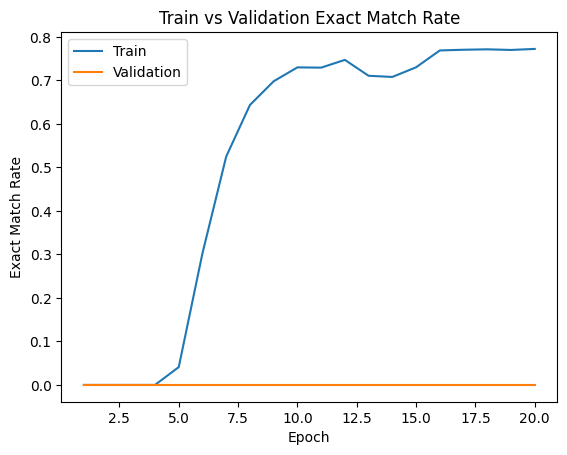

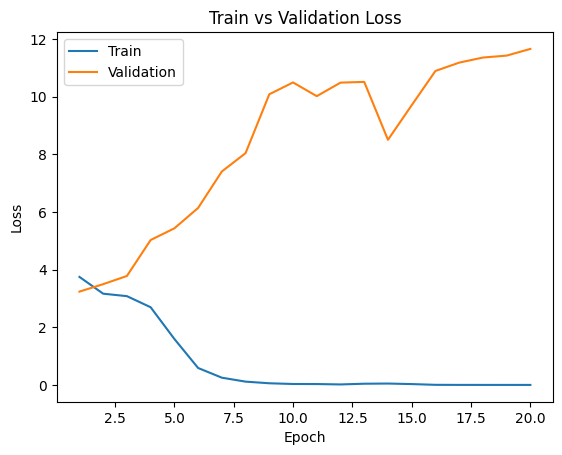

True

In [ ]:
train(model, train_loader, validation_loader, batch_size=32, num_epochs=20, learn_rate=0.0005)

Training Started...
Validation for this epoch Started...
Epoch 1/20, Training Loss: 3.6121, Validation Loss: 3.2668
Epoch 1/20, Training Exact Match Accuracy: 0.0000, Training Average Levenshtein Distance: 9.2652
Epoch 1/20, Validation Exact Match Accuracy: 0.0000, Validation Average Levenshtein Distance: 8.8032
Validation for this epoch Started...
Epoch 2/20, Training Loss: 3.1539, Validation Loss: 3.4187
Epoch 2/20, Training Exact Match Accuracy: 0.0000, Training Average Levenshtein Distance: 9.2425
Epoch 2/20, Validation Exact Match Accuracy: 0.0000, Validation Average Levenshtein Distance: 8.8032
Validation for this epoch Started...
Epoch 3/20, Training Loss: 3.0345, Validation Loss: 4.1275
Epoch 3/20, Training Exact Match Accuracy: 0.0000, Training Average Levenshtein Distance: 8.9628
Epoch 3/20, Validation Exact Match Accuracy: 0.0000, Validation Average Levenshtein Distance: 8.6732
Validation for this epoch Started...
Epoch 4/20, Training Loss: 2.5685, Validation Loss: 4.1140
Ep

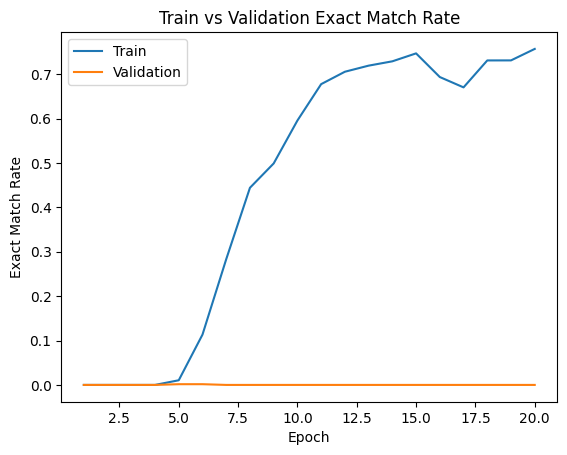

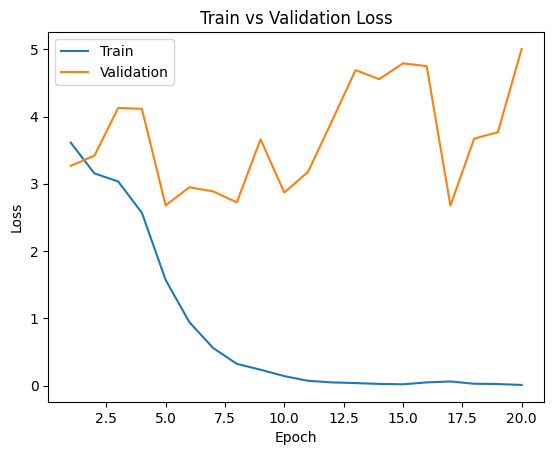

True

In [ ]:
train(model, train_loader, validation_loader, batch_size=64, num_epochs=20, learn_rate=0.001)

Training Started...
Validation for this epoch Started...
Epoch 1/20, Training Loss: 3.5040, Validation Loss: 3.2734
Epoch 1/20, Training Exact Match Accuracy: 0.0000, Training Average Levenshtein Distance: 9.2652
Epoch 1/20, Validation Exact Match Accuracy: 0.0000, Validation Average Levenshtein Distance: 8.8032
Validation for this epoch Started...
Epoch 2/20, Training Loss: 3.1411, Validation Loss: 3.4169
Epoch 2/20, Training Exact Match Accuracy: 0.0000, Training Average Levenshtein Distance: 9.0901
Epoch 2/20, Validation Exact Match Accuracy: 0.0000, Validation Average Levenshtein Distance: 8.4446
Validation for this epoch Started...
Epoch 3/20, Training Loss: 2.9408, Validation Loss: 2.7569
Epoch 3/20, Training Exact Match Accuracy: 0.0000, Training Average Levenshtein Distance: 8.6068
Epoch 3/20, Validation Exact Match Accuracy: 0.0000, Validation Average Levenshtein Distance: 6.9457
Validation for this epoch Started...
Epoch 4/20, Training Loss: 2.2154, Validation Loss: 3.2825
Ep

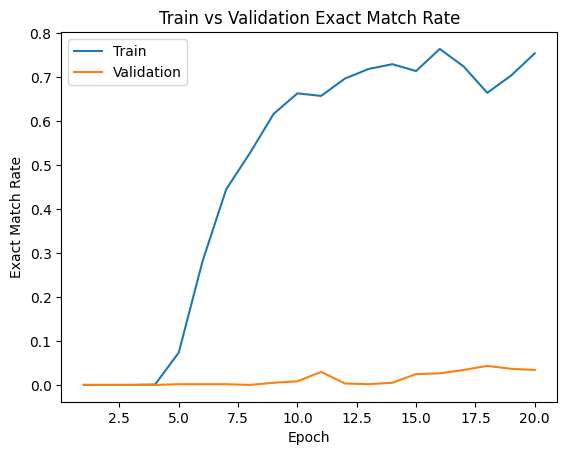

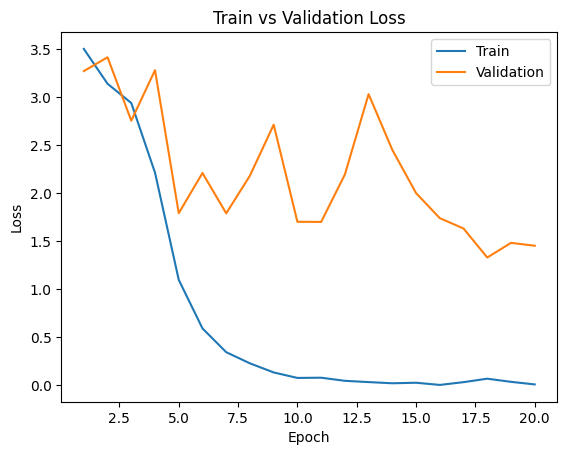

True

In [ ]:
train(model, train_loader, validation_loader, batch_size=128, num_epochs=20, learn_rate=0.002)

Training Started...
Epoch 1/30, Training Loss: 3.4963, Validation Loss: 3.3385
Epoch 1/30, Training Exact Match Accuracy: 0.0000, Training Average Levenshtein Distance: 9.2620
Epoch 1/30, Validation Exact Match Accuracy: 0.0000, Validation Average Levenshtein Distance: 8.8032
Epoch 2/30, Training Loss: 3.2240, Validation Loss: 3.3880
Epoch 2/30, Training Exact Match Accuracy: 0.0000, Training Average Levenshtein Distance: 9.0700
Epoch 2/30, Validation Exact Match Accuracy: 0.0000, Validation Average Levenshtein Distance: 8.6815
Epoch 3/30, Training Loss: 3.1370, Validation Loss: 3.4438
Epoch 3/30, Training Exact Match Accuracy: 0.0000, Training Average Levenshtein Distance: 8.8997
Epoch 3/30, Validation Exact Match Accuracy: 0.0000, Validation Average Levenshtein Distance: 8.5817
Epoch 4/30, Training Loss: 3.0880, Validation Loss: 3.5180
Epoch 4/30, Training Exact Match Accuracy: 0.0000, Training Average Levenshtein Distance: 8.8399
Epoch 4/30, Validation Exact Match Accuracy: 0.0000, 

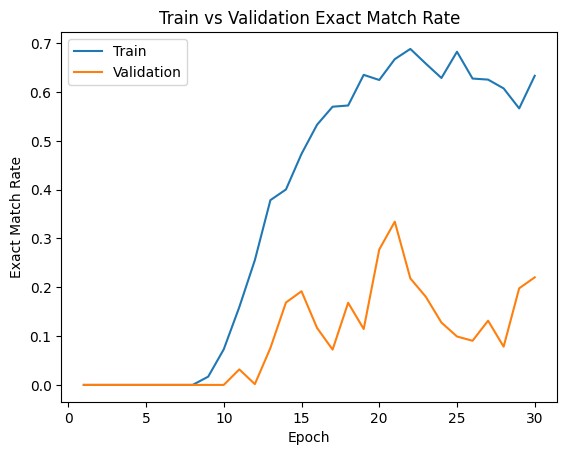

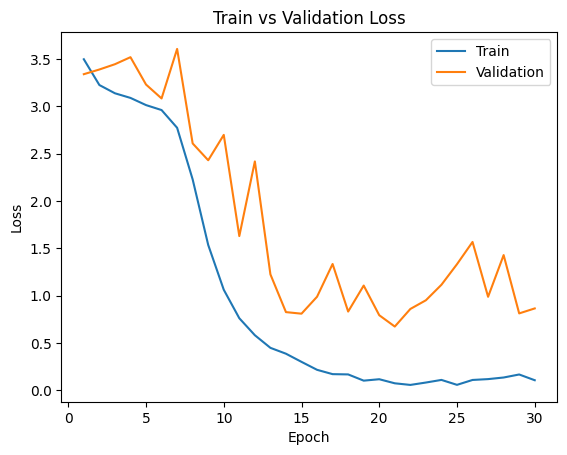

True

In [ ]:
train(model, train_loader, validation_loader, batch_size=128, num_epochs=30, learn_rate=0.005)

Training Started...
Epoch 1/25, Training Loss: 3.5065, Validation Loss: 3.3234
Epoch 1/25, Training Exact Match Accuracy: 0.0000, Training Average Levenshtein Distance: 9.2433
Epoch 1/25, Validation Exact Match Accuracy: 0.0000, Validation Average Levenshtein Distance: 8.8032
Epoch 2/25, Training Loss: 3.2269, Validation Loss: 3.4366
Epoch 2/25, Training Exact Match Accuracy: 0.0000, Training Average Levenshtein Distance: 9.0598
Epoch 2/25, Validation Exact Match Accuracy: 0.0000, Validation Average Levenshtein Distance: 8.8032
Epoch 3/25, Training Loss: 3.1740, Validation Loss: 3.4849
Epoch 3/25, Training Exact Match Accuracy: 0.0000, Training Average Levenshtein Distance: 8.8358
Epoch 3/25, Validation Exact Match Accuracy: 0.0000, Validation Average Levenshtein Distance: 8.7462
Epoch 4/25, Training Loss: 3.1440, Validation Loss: 3.7494
Epoch 4/25, Training Exact Match Accuracy: 0.0000, Training Average Levenshtein Distance: 8.8462
Epoch 4/25, Validation Exact Match Accuracy: 0.0000, 

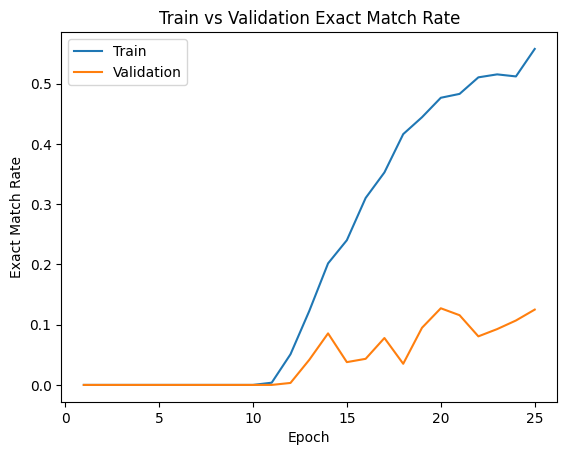

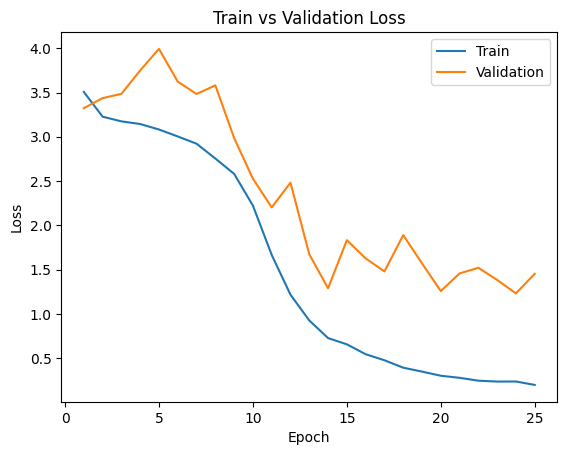

True

In [ ]:
train(model, train_loader, validation_loader, batch_size=256, num_epochs=25, learn_rate=0.005)

Training Started...
Epoch 1/35, Training Loss: 3.4840, Validation Loss: 3.3587
Epoch 1/35, Training Exact Match Accuracy: 0.0000, Training Average Levenshtein Distance: 9.2720
Epoch 1/35, Validation Exact Match Accuracy: 0.0000, Validation Average Levenshtein Distance: 8.8032
Epoch 2/35, Training Loss: 3.2022, Validation Loss: 3.3483
Epoch 2/35, Training Exact Match Accuracy: 0.0000, Training Average Levenshtein Distance: 8.9480
Epoch 2/35, Validation Exact Match Accuracy: 0.0000, Validation Average Levenshtein Distance: 8.7330
Epoch 3/35, Training Loss: 3.1400, Validation Loss: 3.3009
Epoch 3/35, Training Exact Match Accuracy: 0.0000, Training Average Levenshtein Distance: 8.3736
Epoch 3/35, Validation Exact Match Accuracy: 0.0000, Validation Average Levenshtein Distance: 8.3827
Epoch 4/35, Training Loss: 3.0878, Validation Loss: 3.4009
Epoch 4/35, Training Exact Match Accuracy: 0.0000, Training Average Levenshtein Distance: 8.1745
Epoch 4/35, Validation Exact Match Accuracy: 0.0000, 

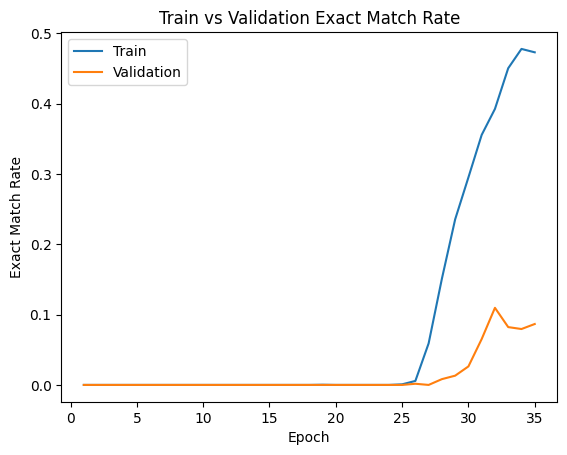

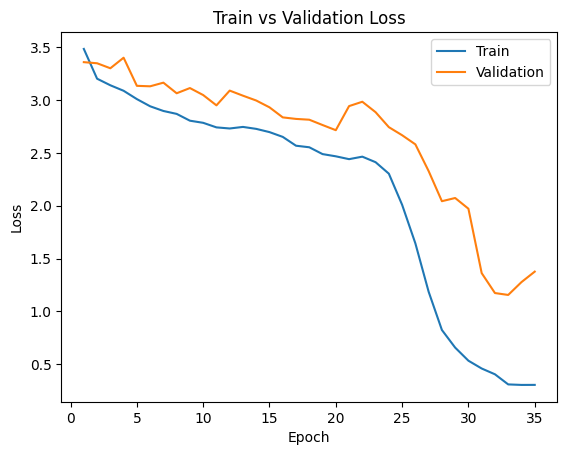

True

In [ ]:
train(model, train_loader, validation_loader, batch_size=256, num_epochs=35, learn_rate=0.005)

# **Training on 10k dataset**

Training Started...
Epoch 1/30, Training Loss: 3.5554, Validation Loss: 3.3192
Epoch 1/30, Training Exact Match Accuracy: 0.0000, Training Average Levenshtein Distance: 9.0120
Epoch 1/30, Validation Exact Match Accuracy: 0.0000, Validation Average Levenshtein Distance: 9.0905
Epoch 2/30, Training Loss: 3.3434, Validation Loss: 3.2932
Epoch 2/30, Training Exact Match Accuracy: 0.0000, Training Average Levenshtein Distance: 9.0203
Epoch 2/30, Validation Exact Match Accuracy: 0.0000, Validation Average Levenshtein Distance: 9.0905
Epoch 3/30, Training Loss: 3.3264, Validation Loss: 3.4212
Epoch 3/30, Training Exact Match Accuracy: 0.0000, Training Average Levenshtein Distance: 9.0205
Epoch 3/30, Validation Exact Match Accuracy: 0.0000, Validation Average Levenshtein Distance: 9.0905
Epoch 4/30, Training Loss: 3.3143, Validation Loss: 3.3368
Epoch 4/30, Training Exact Match Accuracy: 0.0000, Training Average Levenshtein Distance: 9.0206
Epoch 4/30, Validation Exact Match Accuracy: 0.0000, 

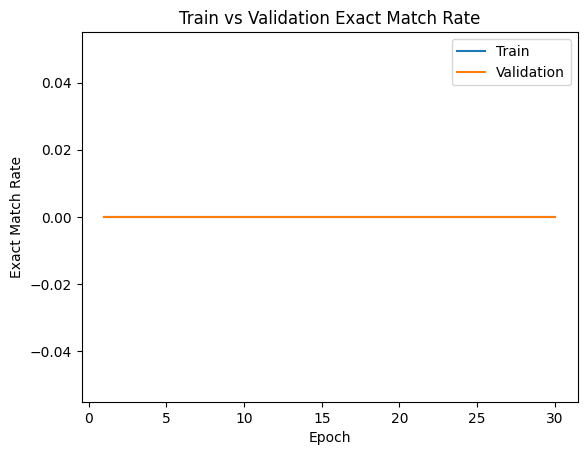

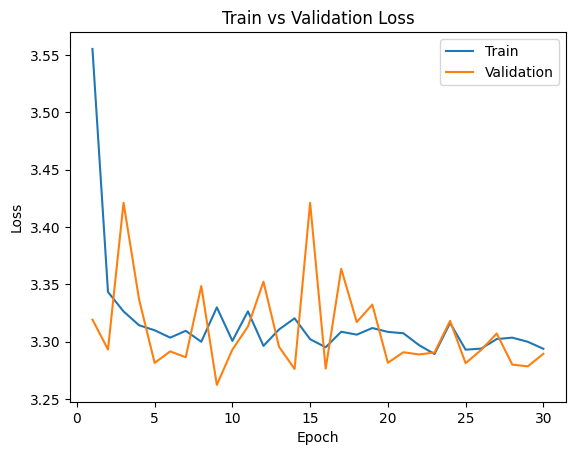

True

In [ ]:
train(model, train_loader, validation_loader, batch_size=256, num_epochs=30, learn_rate=0.01)

Training Started...
Epoch 1/20, Training Loss: 3.3627, Validation Loss: 3.2924
Epoch 1/20, Training Exact Match Accuracy: 0.0000, Training Average Levenshtein Distance: 8.9485
Epoch 1/20, Validation Exact Match Accuracy: 0.0000, Validation Average Levenshtein Distance: 9.0905
Epoch 2/20, Training Loss: 3.1591, Validation Loss: 3.4186
Epoch 2/20, Training Exact Match Accuracy: 0.0000, Training Average Levenshtein Distance: 8.6782
Epoch 2/20, Validation Exact Match Accuracy: 0.0000, Validation Average Levenshtein Distance: 9.0905
Epoch 3/20, Training Loss: 3.1500, Validation Loss: 3.3511
Epoch 3/20, Training Exact Match Accuracy: 0.0000, Training Average Levenshtein Distance: 8.4638
Epoch 3/20, Validation Exact Match Accuracy: 0.0000, Validation Average Levenshtein Distance: 9.0905
Epoch 4/20, Training Loss: 3.1700, Validation Loss: 3.3935
Epoch 4/20, Training Exact Match Accuracy: 0.0000, Training Average Levenshtein Distance: 8.4948
Epoch 4/20, Validation Exact Match Accuracy: 0.0000, 

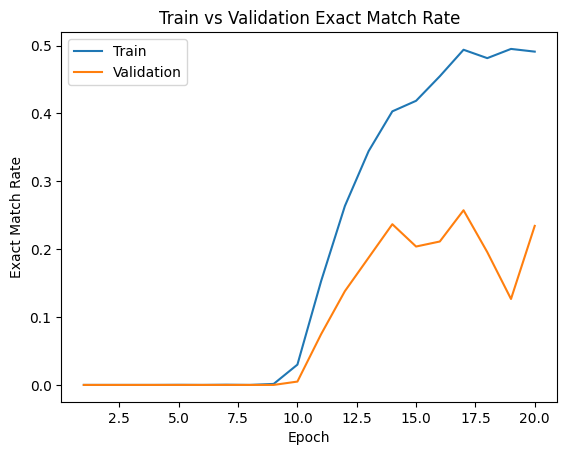

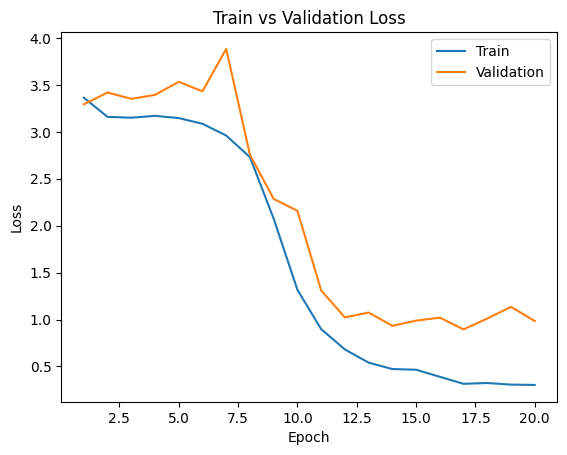

True

In [ ]:
train(model, train_loader, validation_loader, batch_size=256, num_epochs=20, learn_rate=0.005)

Training Started...
Epoch 1/30, Training Loss: 3.3689, Validation Loss: 3.2685
Epoch 1/30, Training Exact Match Accuracy: 0.0000, Training Average Levenshtein Distance: 8.8715
Epoch 1/30, Validation Exact Match Accuracy: 0.0000, Validation Average Levenshtein Distance: 8.9021
Epoch 2/30, Training Loss: 3.1247, Validation Loss: 3.2940
Epoch 2/30, Training Exact Match Accuracy: 0.0000, Training Average Levenshtein Distance: 8.5821
Epoch 2/30, Validation Exact Match Accuracy: 0.0000, Validation Average Levenshtein Distance: 9.0905
Epoch 3/30, Training Loss: 2.9396, Validation Loss: 3.2916
Epoch 3/30, Training Exact Match Accuracy: 0.0000, Training Average Levenshtein Distance: 8.2923
Epoch 3/30, Validation Exact Match Accuracy: 0.0000, Validation Average Levenshtein Distance: 8.5173
Epoch 4/30, Training Loss: 2.4708, Validation Loss: 2.8293
Epoch 4/30, Training Exact Match Accuracy: 0.0000, Training Average Levenshtein Distance: 6.8010
Epoch 4/30, Validation Exact Match Accuracy: 0.0000, 

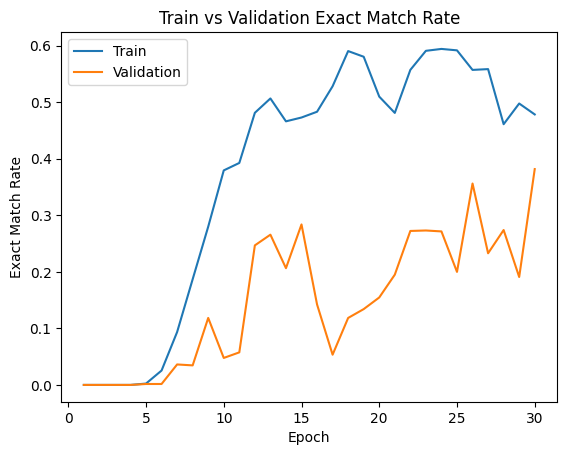

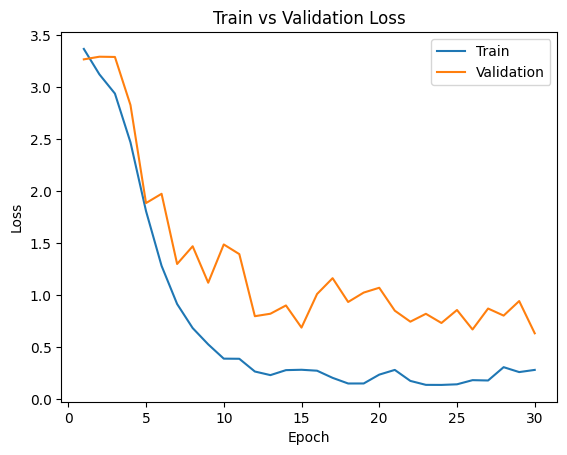

True

In [ ]:
train(model, train_loader, validation_loader, batch_size=512, num_epochs=30, learn_rate=0.005)

Training Started...
Epoch 1/25, Training Loss: 3.3521, Validation Loss: 3.3789
Epoch 1/25, Training Exact Match Accuracy: 0.0000, Training Average Levenshtein Distance: 8.8592
Epoch 1/25, Validation Exact Match Accuracy: 0.0000, Validation Average Levenshtein Distance: 9.0905
Epoch 2/25, Training Loss: 3.1220, Validation Loss: 3.4452
Epoch 2/25, Training Exact Match Accuracy: 0.0000, Training Average Levenshtein Distance: 8.6505
Epoch 2/25, Validation Exact Match Accuracy: 0.0000, Validation Average Levenshtein Distance: 9.0238
Epoch 3/25, Training Loss: 2.9664, Validation Loss: 3.3980
Epoch 3/25, Training Exact Match Accuracy: 0.0006, Training Average Levenshtein Distance: 8.3875
Epoch 3/25, Validation Exact Match Accuracy: 0.0000, Validation Average Levenshtein Distance: 8.0699
Epoch 4/25, Training Loss: 2.5168, Validation Loss: 3.6879
Epoch 4/25, Training Exact Match Accuracy: 0.0004, Training Average Levenshtein Distance: 6.8726
Epoch 4/25, Validation Exact Match Accuracy: 0.0000, 

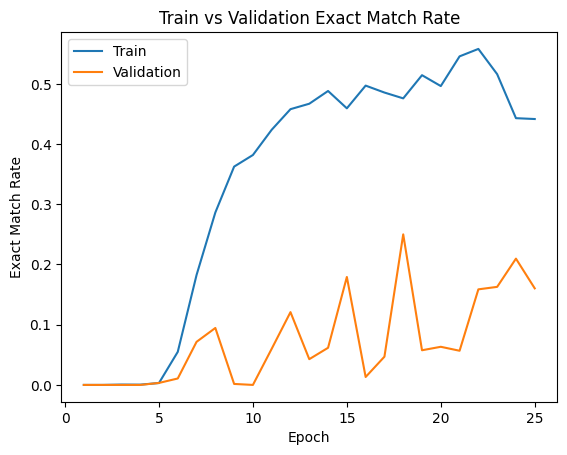

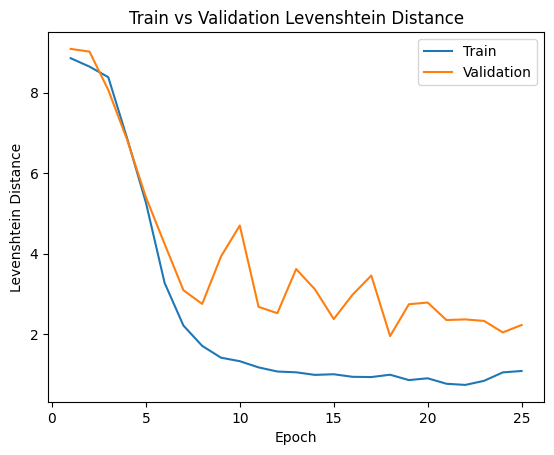

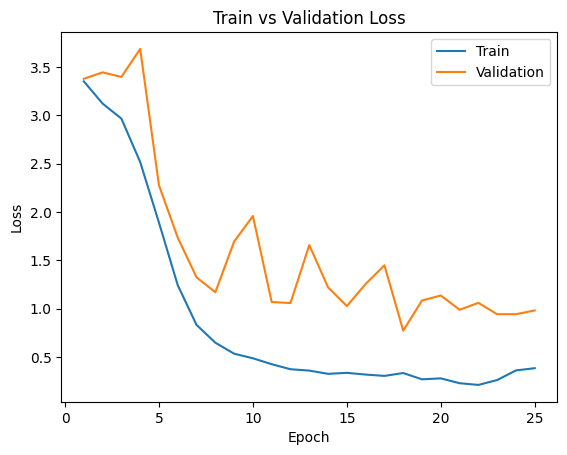

True

In [ ]:
train(model, train_loader, validation_loader, batch_size=512, num_epochs=25, learn_rate=0.005)

Training Started...
Epoch 1/35, Training Loss: 3.3813, Validation Loss: 3.3585
Epoch 1/35, Training Exact Match Accuracy: 0.0000, Training Average Levenshtein Distance: 8.8949
Epoch 1/35, Validation Exact Match Accuracy: 0.0000, Validation Average Levenshtein Distance: 9.0905
Epoch 2/35, Training Loss: 3.1376, Validation Loss: 3.3903
Epoch 2/35, Training Exact Match Accuracy: 0.0003, Training Average Levenshtein Distance: 8.4079
Epoch 2/35, Validation Exact Match Accuracy: 0.0000, Validation Average Levenshtein Distance: 9.0905
Epoch 3/35, Training Loss: 3.0980, Validation Loss: 3.4200
Epoch 3/35, Training Exact Match Accuracy: 0.0000, Training Average Levenshtein Distance: 8.0482
Epoch 3/35, Validation Exact Match Accuracy: 0.0000, Validation Average Levenshtein Distance: 9.0863
Epoch 4/35, Training Loss: 3.0666, Validation Loss: 3.2028
Epoch 4/35, Training Exact Match Accuracy: 0.0000, Training Average Levenshtein Distance: 7.9166
Epoch 4/35, Validation Exact Match Accuracy: 0.0000, 

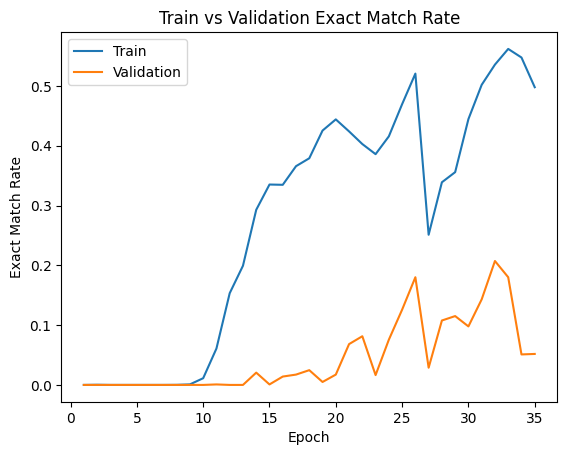

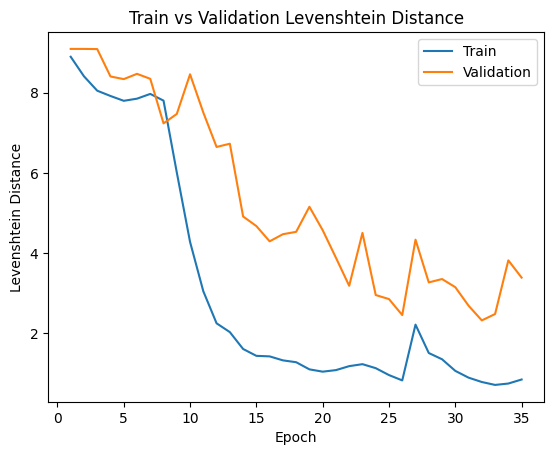

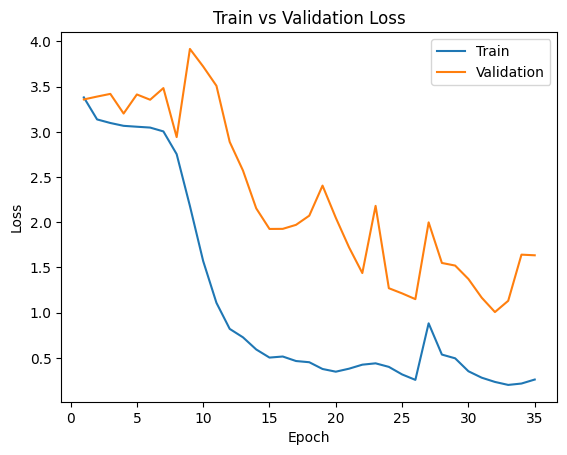

True

In [ ]:
train(model, train_loader, validation_loader, batch_size=256, num_epochs=35, learn_rate=0.005)

Training Started...
Epoch 1/35, Training Loss: 3.3559, Validation Loss: 3.3737
Epoch 1/35, Training Exact Match Accuracy: 0.0000, Training Average Levenshtein Distance: 8.8646
Epoch 1/35, Validation Exact Match Accuracy: 0.0000, Validation Average Levenshtein Distance: 9.0905
Epoch 2/35, Training Loss: 3.1517, Validation Loss: 3.3321
Epoch 2/35, Training Exact Match Accuracy: 0.0000, Training Average Levenshtein Distance: 8.5107
Epoch 2/35, Validation Exact Match Accuracy: 0.0000, Validation Average Levenshtein Distance: 9.0905
Epoch 3/35, Training Loss: 3.1349, Validation Loss: 3.2836
Epoch 3/35, Training Exact Match Accuracy: 0.0000, Training Average Levenshtein Distance: 8.4464
Epoch 3/35, Validation Exact Match Accuracy: 0.0000, Validation Average Levenshtein Distance: 9.0905
Epoch 4/35, Training Loss: 3.0527, Validation Loss: 3.1697
Epoch 4/35, Training Exact Match Accuracy: 0.0000, Training Average Levenshtein Distance: 8.6203
Epoch 4/35, Validation Exact Match Accuracy: 0.0000, 

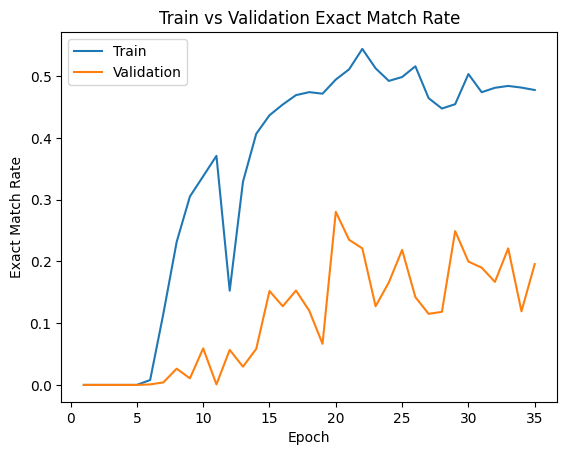

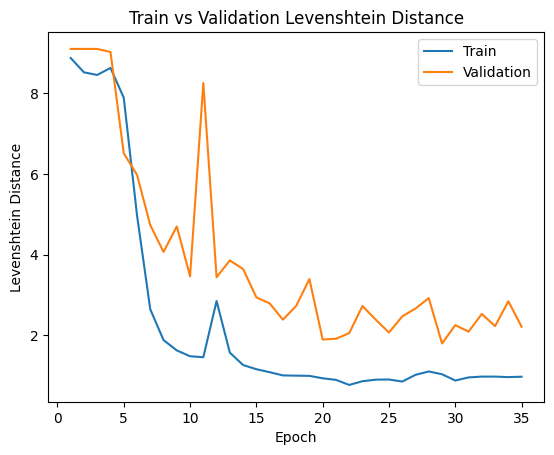

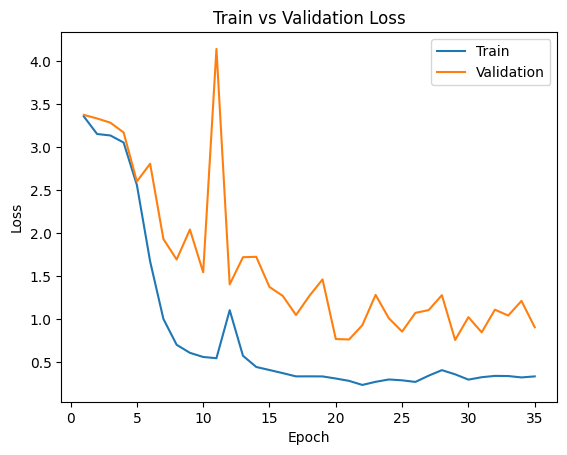

True

In [ ]:
train(model, train_loader, validation_loader, batch_size=512, num_epochs=35, learn_rate=0.005)

In [ ]:
num_classes = len(letters) + 1
model = ImageTextRecognizer(name = "new", img_w=170, img_h=32, num_classes=num_classes, max_length=100)

use_cuda = True
if use_cuda and torch.cuda.is_available():
  model.cuda()
  print('CUDA is available!  Training on GPU ...')
else:
  print('CUDA is not available.  Training on CPU ...')

CUDA is available!  Training on GPU ...


Training Started...
Epoch 1/30, Training Loss: 3.3465, Validation Loss: 3.2588
Epoch 1/30, Training Exact Match Accuracy: 0.0000, Training Average Levenshtein Distance: 8.8401
Epoch 1/30, Validation Exact Match Accuracy: 0.0000, Validation Average Levenshtein Distance: 9.0905
Epoch 2/30, Training Loss: 3.1539, Validation Loss: 3.3475
Epoch 2/30, Training Exact Match Accuracy: 0.0000, Training Average Levenshtein Distance: 8.5035
Epoch 2/30, Validation Exact Match Accuracy: 0.0000, Validation Average Levenshtein Distance: 8.6842
Epoch 3/30, Training Loss: 3.1179, Validation Loss: 3.1873
Epoch 3/30, Training Exact Match Accuracy: 0.0001, Training Average Levenshtein Distance: 8.3411
Epoch 3/30, Validation Exact Match Accuracy: 0.0000, Validation Average Levenshtein Distance: 8.7944
Epoch 4/30, Training Loss: 2.9374, Validation Loss: 3.0699
Epoch 4/30, Training Exact Match Accuracy: 0.0000, Training Average Levenshtein Distance: 8.0601
Epoch 4/30, Validation Exact Match Accuracy: 0.0000, 

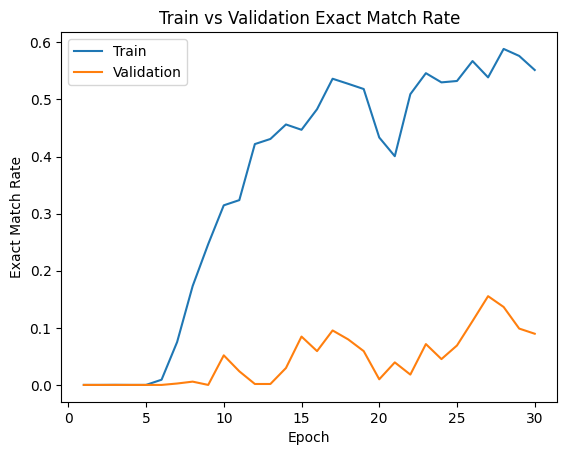

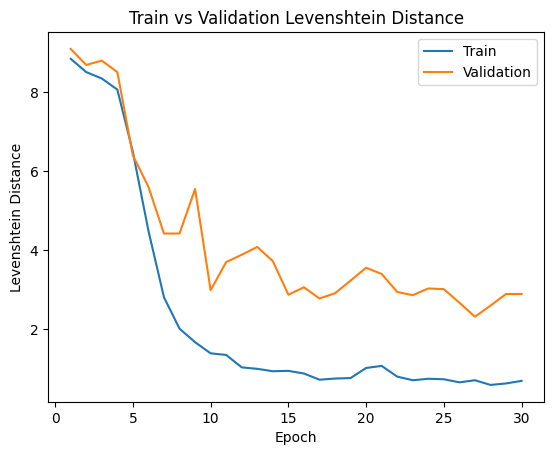

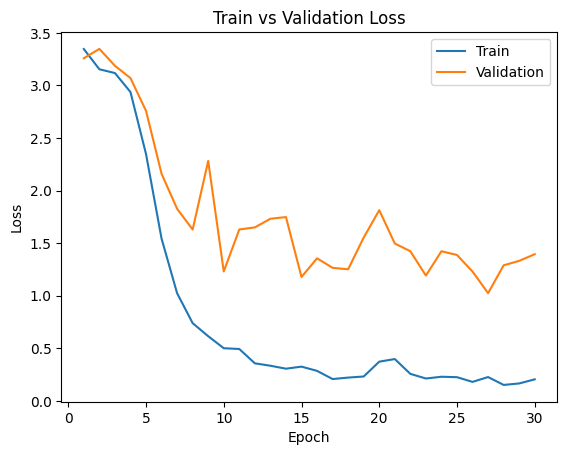

True

In [ ]:
train(model, train_loader, validation_loader, batch_size=512, num_epochs=30, learn_rate=0.005)

# **Testing**

In [ ]:
import torch
import numpy as np

def test(model, test_loader):
    torch.manual_seed(1000)  # For reproducibility
    model.eval()  # Set the model to evaluation mode

    char_dict = create_char_dict(letters)
    index_dict = create_reversed_char_dict(char_dict)
    total_test_loss = 0.0
    total_test_accur = 0.0
    total_test_leven = 0.0
    empty_output_count = 0  # To track the number of empty outputs
    total_samples = 0  # To track the total number of samples processed

    with torch.no_grad():  # No need to track gradients
        for imgs, labels, input_lengths, label_lengths in test_loader:
            imgs = imgs.cuda() if torch.cuda.is_available() else imgs
            labels = labels.cuda() if torch.cuda.is_available() else labels

            logits = model(imgs)
            input_lengths = torch.tensor([logits.size(0)] * logits.shape[1], dtype=torch.int32)

            loss_test = ctc_loss(logits, labels, input_lengths, label_lengths)
            total_test_loss += loss_test.item()

            # Decode predictions
            _, preds = torch.max(logits, 2)
            preds = preds.transpose(1, 0).contiguous().view(-1)
            decoded_batch = batch_decode_ctc(preds, input_lengths, index_dict)
            ground_truth = groundtruth_decode_ctc(labels, label_lengths, index_dict)
            print(decoded_batch)
            print(ground_truth)
            total_test_accur += calculate_exact_match_accuracy(decoded_batch, ground_truth)
            total_test_leven += calculate_average_levenshtein(decoded_batch, ground_truth)

            # Count empty outputs
            empty_output_count += sum([1 for decoded in decoded_batch if decoded == ""])
            total_samples += len(decoded_batch)

    # Calculate average metrics and failure rate
    avg_test_loss = total_test_loss / len(test_loader)
    avg_test_accur = total_test_accur / len(test_loader)
    avg_test_leven = total_test_leven / len(test_loader)
    failure_rate = (empty_output_count / total_samples) * 100  # Calculate as a percentage


    avg_test_accur = avg_test_accur * 100
    print(f"Test Loss: {avg_test_loss:.4f}")
    print(f"Test Exact Match Accuracy: {avg_test_accur:.4f}%")
    print(f"Test Average Levenshtein Distance: {avg_test_leven:.4f}")
    print(f"Failure Rate (Empty Outputs): {failure_rate:.2f}%")

    return avg_test_loss, avg_test_accur, avg_test_leven, failure_rate

In [ ]:
test(model, test_loader)

Test Loss: 0.6298
Test Exact Match Accuracy: 0.3755
Test Average Levenshtein Distance: 1.3755
Failure Rate (Empty Outputs): 0.00%


(0.6298388153837439, 0.3755482456140351, 1.375548245614035, 0.0)

In [ ]:
test(model, test_loader)

Test Loss: 1.5964
Test Exact Match Accuracy: 0.0526
Test Average Levenshtein Distance: 3.4446
Failure Rate (Empty Outputs): 0.00%


(1.596353620813604, 0.05263157894736842, 3.4446271929824563, 0.0)

In [ ]:
test(model, test_loader)

['GENUA', 'JACALES', 'CONSUMPTIVELY', 'PALMITONE', 'BLASTOCOELIC', 'CANIER', 'FIBROUS', 'CLINOCLASITE', 'ULTRACENTRIFUGING', 'POROPHYLOUS', 'PROPYLITIC', 'BRY-', 'INTERNECTION', 'MISANTHROPIST', 'STEADY-HANDED', 'PRO-ISRAEL', 'SANTANDER', 'BESCRATCH', 'BOUNDERS', 'ULTRA-PECKSNIFIAN', 'DERIVATION', 'UROGRAPHY', 'HEDERIGERENT', 'INSCRUTABLENES', 'MCROBERTS', 'HISTORICISM', 'CRIANCE', 'FIERCE-MINDED', 'VARIOLATED', 'RECO', 'OUTWEAR', 'ORG']
['PETERNET', 'NONLOVER', 'ONONDAGAN', 'SUBTILER', 'REINECKE', 'PREMORALITY', 'FOREBODES', 'GLENO-', 'DERAIGN', 'UNSTEALTHILY', 'SEMICOLONS', 'QV', 'LOCKNUTS', 'PRESURES', 'PARVENUDOM', 'POST-PALEOLITHIC', 'DEMONOLATROUSLY', 'GROGIER', 'DICTATORSHIPS', 'FOUR-WEK', 'MISTENDED', 'CALCAREOUSLY', 'PANTHERISH', 'NITPICK', 'SYNENTOGNATHI', 'ABATED', 'BACKBAR', 'HEADROPE', 'TWICE-WARNED', 'INGLESIDE', 'GROWLED', 'VADIM']
['TENFOLDNES', 'STICHTER', 'BOGYS', 'SEMPACH', 'METALUMINATE', 'BADALONA', 'SIDELOCK', 'CATALEPTICALY', 'FORMATED', 'STADA', 'SICKEN', 'DEBOR

(0.8518672867825157, 21.655701754385966, 2.119517543859649, 0.1111111111111111)

In [ ]:
test(model, test_loader)

['OGENUE', 'IACALES', 'TONSUMPTIWELY', 'PALMITONE', 'BLASTOCOEDIC', 'RCOMMIER', 'ONFIBROUS', 'CLINOTLASITE', 'UUHTATENTIUGING', 'PPROPHYOUS', 'OPRRORPYIIIIKC', 'BPI-', 'INTERNECTION', 'MISANTHROPIST', 'STEAAY-HAMDED', 'PROPLSRAE', 'SANTANDER', 'BESTRATCH', 'BOUNDERS', 'WHRA-PETSNIIAN', 'DERIVATIOMS', 'UROGRAPHY', 'HEDETIGETENT', 'IMSCUTABLEMESS', 'MCROBERTS', 'HISTORICISM', 'ACRIANCE', 'FIERTE-MIMDED', 'WANIOLATEO', 'RECCO', 'OUTWWEAR', 'OTG']
['PETERNET', 'NONLOVER', 'PDWDAPAN', 'SUBTILER', 'REIMECKE', 'PREMORAITY', 'FOREBBDES', 'GHEMOR', 'DERAIGM', 'UMSTEALTHILY', 'SEMMICOLONG', 'OCWTN', 'OOCKMWTS', 'PRESSARES', 'PAENUDOM', 'PPSR-PALEOITHIC', 'OEMOMOLAIROSLY', 'GROGGIER', 'DICTATPRSHIPS', 'FOUMPWWEER', 'MISTENDED', 'CALCAREPUSLY', 'PANNWERISN', 'OMITPICK', 'SYNENTOGNATHI', 'ABATED', 'BACOBAOP', 'HEADROPE', 'PEGTRADEY', 'INGESIDE', 'GROWLED', 'MADIMM']
['TEMFPLDNESS', 'STICHTER-', 'BOGYS', 'SEMMPACH', 'METALUMIMATE', 'IBADALONA', 'SIDELOCK', 'CATALEPTICALLY', 'FOMMATTED', 'ROTTWRWTWW'

(0.8518672867825157, 21.655701754385966, 2.119517543859649, 0.1111111111111111)

In [ ]:
model.load_state_dict(torch.load("model_model_bs512_lr0.005_epoch34"))

<All keys matched successfully>

In [ ]:
test(model, test_loader)

['GENUA', 'JACALES', 'CONSUMPTIVELY', 'PALMITONE', 'BLASTOCOELIC', 'CANIER', 'FIBROUS', 'CLINOCLASITE', 'ULTRACENTRIFUGING', 'POROPHYLOUS', 'PROPYLITIC', 'BRY-', 'INTERNECTION', 'MISANTHROPIST', 'STEADY-HANDED', 'PRO-ISRAEL', 'SANTANDER', 'BESCRATCH', 'BOUNDERS', 'ULTRA-PECKSNIFIAN', 'DERIVATION', 'UROGRAPHY', 'HEDERIGERENT', 'INSCRUTABLENES', 'MCROBERTS', 'HISTORICISM', 'CRIANCE', 'FIERCE-MINDED', 'VARIOLATED', 'RECO', 'OUTWEAR', 'ORG']
['PETERNET', 'NONLOVER', 'ONONDAGAN', 'SUBTILER', 'REINECKE', 'PREMORALITY', 'FOREBODES', 'GLENO-', 'DERAIGN', 'UNSTEALTHILY', 'SEMICOLONS', 'QV', 'LOCKNUTS', 'PRESURES', 'PARVENUDOM', 'POST-PALEOLITHIC', 'DEMONOLATROUSLY', 'GROGIER', 'DICTATORSHIPS', 'FOUR-WEK', 'MISTENDED', 'CALCAREOUSLY', 'PANTHERISH', 'NITPICK', 'SYNENTOGNATHI', 'ABATED', 'BACKBAR', 'HEADROPE', 'TWICE-WARNED', 'INGLESIDE', 'GROWLED', 'VADIM']
['TENFOLDNES', 'STICHTER', 'BOGYS', 'SEMPACH', 'METALUMINATE', 'BADALONA', 'SIDELOCK', 'CATALEPTICALY', 'FORMATED', 'STADA', 'SICKEN', 'DEBOR

(0.8518672867825157, 21.655701754385966, 2.119517543859649, 0.1111111111111111)

# **Demonstration**

In [ ]:
test_dir = '/content/drive/My Drive/demo'

In [ ]:
#preprocessing for easier learning:
def preprocess_images(directory, target_size=(170, 32), color_mode='grayscale'):
    for img_name in os.listdir(directory):
        img_path = os.path.join(directory, img_name)
        img = Image.open(img_path)

        # Resize image
        img = img.resize(target_size, Image.ANTIALIAS)

        # Convert to grayscale
        if color_mode == 'grayscale':
            img = img.convert('L')

        # Normalize pixel values
        img_array = np.asarray(img) / 255.0

        # Save preprocessed image
        img = Image.fromarray((img_array * 255).astype(np.uint8))
        img.save(img_path)

# Apply preprocessing to each dataset split
preprocess_images(test_dir)

print('Preprocessing complete.')

Preprocessing complete.


<ipython-input-20-8bf3357baffb>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = img.resize(target_size, Image.ANTIALIAS)


In [ ]:
char_dict = create_char_dict(letters)
test_dataset = ImageDataset(directory='/content/drive/My Drive/demo', transform=transformations, char_dict = char_dict)

test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, collate_fn=custom_collate_fn)

testing_samples = len(test_loader.dataset)

print(f"Total number of testing samples: {testing_samples}")

Total number of testing samples: 1


In [ ]:
model.load_state_dict(torch.load("model_model_bs512_lr0.005_epoch34"))

<All keys matched successfully>

In [ ]:
test(model, test_loader)

['NNPN']
['WHEN']
Test Loss: 5.2067
Test Exact Match Accuracy: 0.0000%
Test Average Levenshtein Distance: 3.0000
Failure Rate (Empty Outputs): 0.00%


(5.206690788269043, 0.0, 3.0, 0.0)